In [1]:
import pandas as pd
import numpy as np
import string

Using TensorFlow backend.


In [2]:
lines= pd.read_table('C:/Users/ysp/Desktop/Deep Learning/english to french.txt', names=['eng', 'fr'])

In [3]:
lines = lines[0:50000]
print(lines.head(3))
print(lines.tail(3))

    eng        fr
0   Go.      Va !
1  Run!   Cours !
2  Run!  Courez !
                            eng                              fr
49997  They go to work on foot.     Ils vont au travail à pied.
49998  They got into the train.    Ils montèrent dans le train.
49999  They got into the train.  Elles montèrent dans le train.


In [4]:
lines['eng']=lines['eng'].apply(lambda x: x.lower())
lines['fr']=lines['fr'].apply(lambda x: x.lower())

In [5]:
exclude = set(string.punctuation)
lines.eng=lines.eng.apply(lambda x: ''.join(ch for ch in x if ch not in exclude))
lines.fr=lines.fr.apply(lambda x: ''.join(ch for ch in x if ch not in exclude))

In [6]:
print(lines.head(3))
print(lines.tail(3))

   eng       fr
0   go      va 
1  run   cours 
2  run  courez 
                           eng                             fr
49997  they go to work on foot     ils vont au travail à pied
49998  they got into the train    ils montèrent dans le train
49999  they got into the train  elles montèrent dans le train


In [7]:
lines.fr = lines.fr.apply(lambda x : 'start '+ x + ' end')

In [8]:
print(lines.head(3))
print(lines.tail(3))

   eng                 fr
0   go      start va  end
1  run   start cours  end
2  run  start courez  end
                           eng                                       fr
49997  they go to work on foot     start ils vont au travail à pied end
49998  they got into the train    start ils montèrent dans le train end
49999  they got into the train  start elles montèrent dans le train end


In [9]:
lines.shape

(50000, 2)

In [10]:
# fit a tokenizer
from keras.preprocessing.text import Tokenizer
def create_tokenizer(lines):
	tokenizer = Tokenizer()
	tokenizer.fit_on_texts(lines)
	return tokenizer

In [11]:
import json
eng_tokenizer = create_tokenizer(lines['eng'])
eng_dict=json.loads(json.dumps(eng_tokenizer.word_counts))
df =pd.DataFrame([eng_dict.keys(), eng_dict.values()]).T
df.columns = ['word','count']
df = df.sort_values(by='count',ascending = False)
df['cum_count']=df['count'].cumsum()
df['cum_perc'] = df['cum_count']/df['cum_count'].max()
final_eng_words = df[df['cum_perc']<0.8]['word'].values

In [12]:
fr_tokenizer = create_tokenizer(lines['fr'])
fr_dict = json.loads(json.dumps(fr_tokenizer.word_counts))
df =pd.DataFrame([fr_dict.keys(), fr_dict.values()]).T
df.columns = ['word','count']
df = df.sort_values(by='count',ascending = False)
df['cum_count']=df['count'].cumsum()
df['cum_perc'] = df['cum_count']/df['cum_count'].max()
final_fr_words = df[df['cum_perc']<0.8]['word'].values

In [13]:
print(len(final_eng_words),len(final_fr_words))

384 357


In [14]:
def filter_eng_words(x):
  t = []
  x = x.split()
  for i in range(len(x)):
    if x[i] in final_eng_words:
      t.append(x[i])
    else:
      t.append('unk')
  x3 = ''
  for i in range(len(t)):
    x3 = x3+t[i]+' '
  return x3

In [15]:
filter_eng_words('he is extremely good')

'he is unk good '

In [16]:
def filter_fr_words(x):
  t = []
  x = x.split()
  for i in range(len(x)):
    if x[i] in final_fr_words:
      t.append(x[i])
    else:
      t.append('unk')
  x3 = ''
  for i in range(len(t)):
    x3 = x3+t[i]+' '
  return x3

In [17]:
lines['eng']=lines['eng'].apply(filter_eng_words)

In [18]:
lines['fr']=lines['fr'].apply(filter_fr_words)

In [19]:
all_eng_words=set()
for eng in lines.eng:
    for word in eng.split():
        if word not in all_eng_words:
            all_eng_words.add(word)
    
all_french_words=set()
for fr in lines.fr:
    for word in fr.split():
        if word not in all_french_words:
            all_french_words.add(word)

In [20]:
input_words = sorted(list(all_eng_words))
target_words = sorted(list(all_french_words))
num_encoder_tokens = len(all_eng_words)
num_decoder_tokens = len(all_french_words)
# del all_eng_words, all_french_words

In [21]:
set(all_french_words) - set(final_fr_words) 

{'unk'}

In [22]:
len(all_eng_words)

385

In [23]:
len(target_words)

358

In [24]:
input_token_index = dict(
    [(word, i+1) for i, word in enumerate(input_words)])
target_token_index = dict(
    [(word, i+1) for i, word in enumerate(target_words)])

In [25]:
num_decoder_tokens

358

In [26]:
print(input_token_index['unk'])
print(target_token_index['start'])
print(target_token_index['end'])
print(list(input_token_index.keys())[335])
print(list(target_token_index.keys())[283])
print(list(target_token_index.keys())[88])

336
284
89
unk
start
end


In [27]:
length_list=[]
for l in lines.fr:
    length_list.append(len(l.split(' ')))
fr_max_length = np.max(length_list)

In [28]:
length_list=[]
for l in lines.eng:
    length_list.append(len(l.split(' ')))
eng_max_length = np.max(length_list)

In [29]:
print(eng_max_length)
print(fr_max_length)

8
17


In [30]:
encoder_input_data = np.zeros(
    (len(lines['eng']), eng_max_length),
    dtype='float32')
decoder_input_data = np.zeros(
    (len(lines['fr']), fr_max_length),
    dtype='float32')
decoder_target_data = np.zeros(
    (len(lines['fr']), fr_max_length, num_decoder_tokens+1),
    dtype='float32')

In [31]:
decoder_target_data.shape

(50000, 17, 359)

In [32]:
for i, (input_text, target_text) in enumerate(zip(lines['eng'], lines['fr'])):
    for t, word in enumerate(input_text.split()):
        encoder_input_data[i, t] = input_token_index[word]
    for t, word in enumerate(target_text.split()):
        decoder_input_data[i, t] = target_token_index[word]
        if t>0:
            decoder_target_data[i, t - 1, target_token_index[word]] = 1.
            if t== len(target_text.split())-1:
                decoder_target_data[i, t:, 89] = 1

In [33]:
print(decoder_input_data.shape,encoder_input_data.shape,decoder_target_data.shape)

(50000, 17) (50000, 8) (50000, 17, 359)


In [34]:
for i in range(decoder_input_data.shape[0]):
    for j in range(decoder_input_data.shape[1]):
        if(decoder_input_data[i][j]==0):
            decoder_input_data[i][j] = 89

In [35]:
from keras.models import Model
from keras.layers import Input, LSTM, Dense, Embedding, Dropout, Activation, concatenate
encoder_inputs = Input(shape=(eng_max_length,))
en_x=  Embedding(num_encoder_tokens+1, 128)(encoder_inputs)
en_x = Dropout(0.1)(en_x)
encoder_outputs, state_h, state_c = LSTM(256, return_sequences=True, return_state=True)(en_x)
encoder_states=[state_h, state_c]

decoder_inputs = Input(shape=(fr_max_length,))
dex=  Embedding(num_decoder_tokens+1,128)(decoder_inputs)
decoder = Dropout(0.1)(dex)
decoder = LSTM(256, return_sequences=True)(decoder, initial_state=encoder_states)
print('decoder', decoder)

decoder Tensor("lstm_2/transpose_1:0", shape=(None, 17, 256), dtype=float32)


In [36]:
t = Dense(5000, activation='tanh')(encoder_outputs)
t1 = Dense(5000, activation='tanh')(decoder)
print(t)
print(t1)

Tensor("dense_1/Tanh:0", shape=(None, 8, 5000), dtype=float32)
Tensor("dense_2/Tanh:0", shape=(None, 17, 5000), dtype=float32)


In [37]:
from keras.layers import dot
attention = dot([t1, t], axes=[2, 2])
attention

<tf.Tensor 'dot_1/MatMul:0' shape=(None, 17, 8) dtype=float32>

In [38]:
attention = Dense(eng_max_length, activation='tanh')(attention)
attention = Activation('softmax')(attention)
context = dot([attention, encoder_outputs], axes = [2,1])
print('attention', attention)
print('context', context)

attention Tensor("activation_1/truediv:0", shape=(None, 17, 8), dtype=float32)
context Tensor("dot_2/MatMul:0", shape=(None, 17, 256), dtype=float32)


In [39]:
decoder_combined_context = concatenate([context, decoder])
print('decoder_combined_context', decoder_combined_context)

decoder_combined_context Tensor("concatenate_1/concat:0", shape=(None, 17, 512), dtype=float32)


In [40]:
decoder_combined_context = Dense(2000, activation='tanh')(decoder_combined_context)
output = Dense( num_decoder_tokens+1, activation="softmax")(decoder_combined_context)
print('output', output)

output Tensor("dense_5/truediv:0", shape=(None, 17, 359), dtype=float32)


In [41]:
model3 = Model(inputs=[encoder_inputs, decoder_inputs], outputs=[output])
model3.compile(optimizer='adam', loss='categorical_crossentropy',metrics = ['accuracy'])

In [42]:
model3.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 8)            0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 17)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 8, 128)       49408       input_1[0][0]                    
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 17, 128)      45952       input_2[0][0]                    
____________________________________________________________________________________________

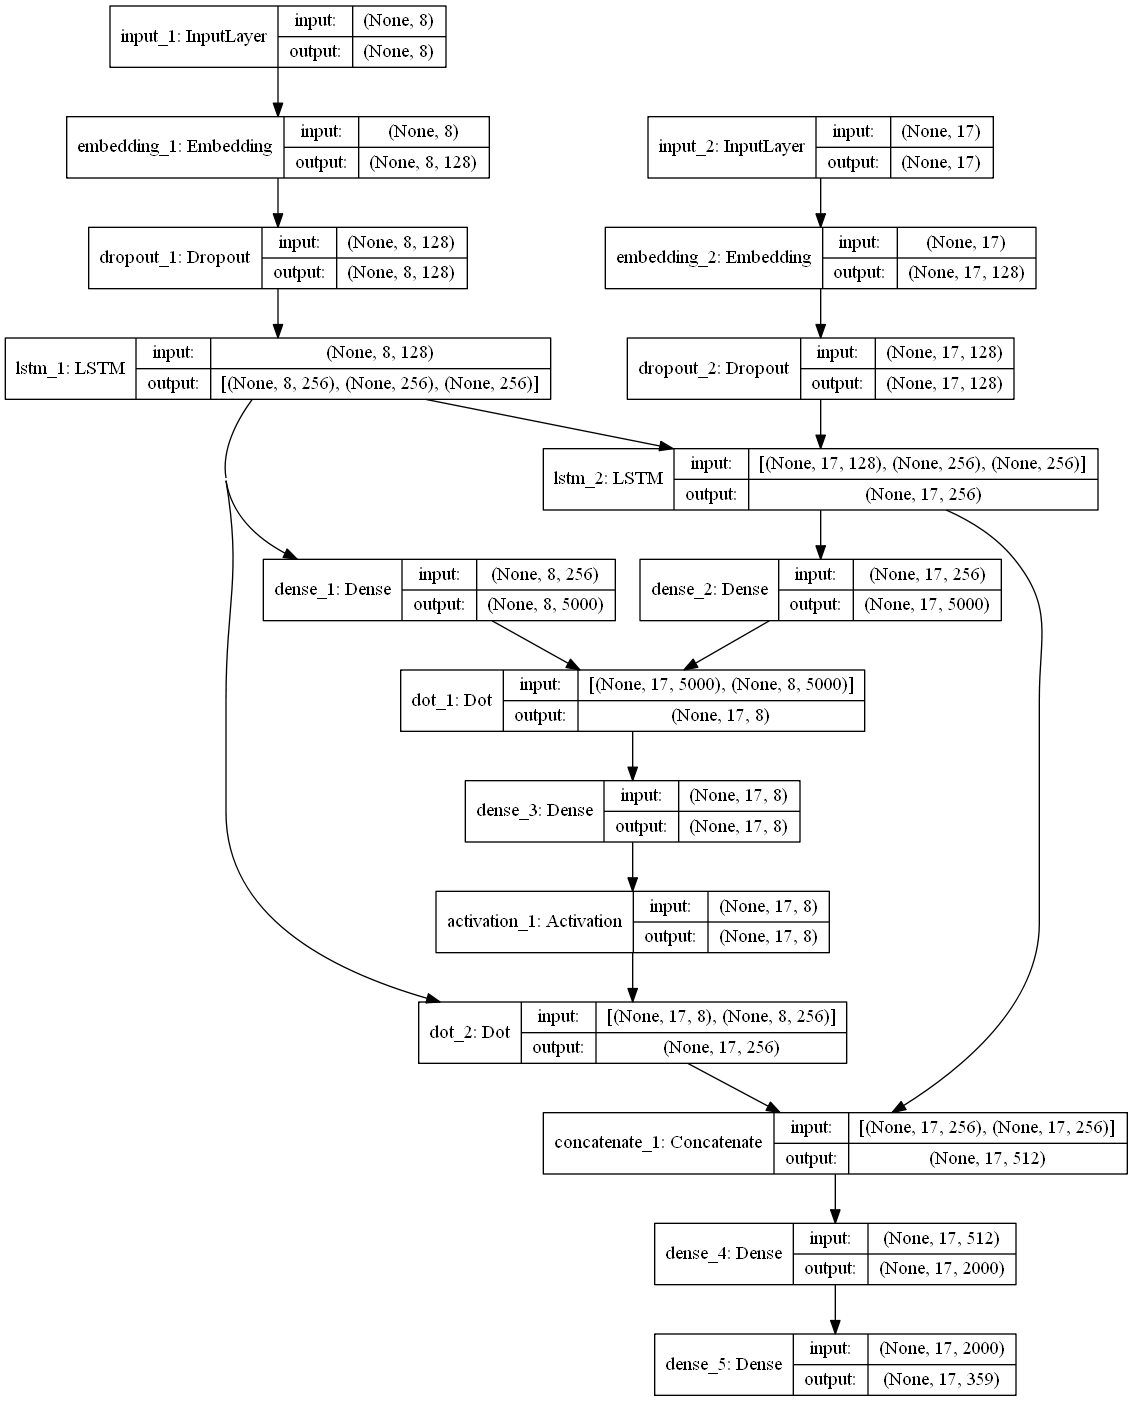

In [43]:
from keras.utils import plot_model
plot_model(model3, show_shapes=True, show_layer_names=True, to_file='model.png')
from IPython.display import Image
Image(retina=True, filename='model.png')

In [44]:
history3 = model3.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size=32,
          epochs=5,
          validation_split=0.05)

C:\Users\ysp\anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 47500 samples, validate on 2500 samples
Epoch 1/5
47500/47500 [==============================] - 157s 3ms/step - loss: 0.7278 - accuracy: 0.8502 - val_loss: 0.7057 - val_accuracy: 0.8307
Epoch 2/5
47500/47500 [==============================] - 159s 3ms/step - loss: 0.4367 - accuracy: 0.8893 - val_loss: 0.5934 - val_accuracy: 0.8528
Epoch 3/5
47500/47500 [==============================] - 159s 3ms/step - loss: 0.3772 - accuracy: 0.9003 - val_loss: 0.5501 - val_accuracy: 0.8574
Epoch 4/5
47500/47500 [==============================] - 158s 3ms/step - loss: 0.3340 - accuracy: 0.9087 - val_loss: 0.5182 - val_accuracy: 0.8658
Epoch 5/5
47500/47500 [==============================] - 158s 3ms/step - loss: 0.3114 - accuracy: 0.9135 - val_loss: 0.5100 - val_accuracy: 0.8659


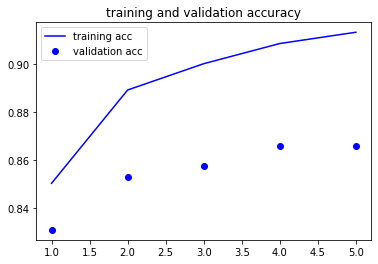

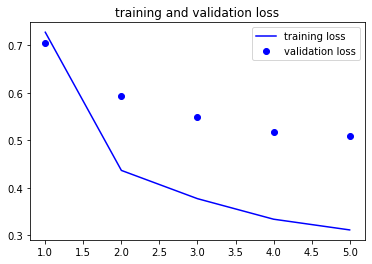

In [45]:
import matplotlib.pyplot as plt
acc=history3.history['accuracy']
val_acc=history3.history['val_accuracy']
loss=history3.history['loss']
val_loss=history3.history['val_loss']
epochs=range(1,len(acc)+1)
plt.plot(epochs,acc,'b',label='training acc')
plt.plot(epochs,val_acc,'bo',label='validation acc')
plt.title('training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs,loss,'b',label='training loss')
plt.plot(epochs,val_loss,'bo',label='validation loss')
plt.title('training and validation loss')
plt.legend()
plt.show()

In [46]:
decoder_input_data_pred = np.zeros(
    (len(lines.fr), fr_max_length),
    dtype='float32')

final_pred_att = []
for i in range(2500):
  word = 284
  for j in range(17):
    decoder_input_data_pred[(47500+i), j] = word
    pred = model3.predict([encoder_input_data[(47500+i)].reshape(1,8),decoder_input_data_pred[47500+i].reshape(1,17)])
    t = np.argmax(pred[0][j])
    word = t
    if word==89:
      break
  final_pred_att.append(list(decoder_input_data_pred[47500+i]))

In [47]:
final_pred2_att = np.array(final_pred_att)
count = 0
correct_count = 0

for i in range(2500):
  correct_count += np.sum((decoder_input_data[47500+i]==final_pred2_att[i]) & (decoder_input_data[47500+i]!=89))
  count += np.sum(decoder_input_data[47500+i]!=89)
correct_count/count  

0.5117418058520659

In [ ]:
k = -2400

In [190]:
t = model3.predict([encoder_input_data[k].reshape(1,encoder_input_data.shape[1]),decoder_input_data[k].reshape(1,decoder_input_data.shape[1])]).reshape(decoder_input_data.shape[1], num_decoder_tokens+1)

In [191]:
for i in range(len(encoder_input_data[k])):
  if int(encoder_input_data[k][i])!=0:
    print(list(input_token_index.keys())[int(encoder_input_data[k][i]-1)])

i
need
you
to
leave
now


In [192]:
t2 = np.argmax(t,axis=1)
for i in range(len(t2)):
  if int(t2[i])!=0:
    print(list(target_token_index.keys())[int(t2[i]-1)])

jai
besoin
que
tu
unk
maintenant
end
end
end
end
end
end
end
end
end
end
end


In [193]:
t2 = decoder_input_data[k]
for i in range(len(t2)):
  if int(t2[i])!=0:
    print(list(target_token_index.keys())[int(t2[i]-1)])

start
jai
besoin
que
tu
unk
maintenant
end
end
end
end
end
end
end
end
end
end
